## Sensitivity of the simulation 

We want to know how sensitive a particular metric is to resolution and tuning coeff. 

In [1]:
import xarray as xr
import xrft
import matplotlib.pyplot as plt
import numpy as np
from xgcm import Grid
from datatree import open_datatree, DataTree 

import sys
sys.path.append('../modules/')

%reload_ext autoreload
%autoreload 2

In [2]:
from prepare_experiments import load_config
from sim_analysis_modules import create_leaf, analyze_sims

In [3]:
import sim_analysis_modules as sam

In [64]:
res = [10, 20, 40, 80]
res_bins = [5, 15, 30, 60, 100]
C_ANN          = np.array([0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 3.0])
C_ANN_bins = np.array([-0.1, 0.125, 0.325, 0.625, 0.825, 1.125, 1.325,1.625, 1.825, 2.125, 2.325, 2.75, 3.5])
C_GM = np.array([10, 50, 100, 500, 1000, 2000, 4000, 8000, 12000])/1000
C_GM_bins = np.array([0, 25, 75, 300, 750, 1500, 3000, 6000, 10000, 14000])
model_types = ['ANN', 'GM1000']

exp_dir = '/scratch/db194/mom6/base_experiments_2025/Phillip2Layer/27Mar/'

In [66]:
len(C_ANN_bins)

13

In [67]:
C_GM_offline_P2L = [137, 596, 2287, 6266]

In [5]:
# Load HR model
dir_HR = '/scratch/db194/mom6/base_experiments_2025/Phillip2Layer/Phillips_2layer_4km/'
ds_HR = xr.open_dataset(dir_HR+'prog.nc', decode_times=False)

ERROR 1: PROJ: proj_create_from_database: Open of /ext3/miniforge/share/proj failed


In [6]:
ds_HR = sam.add_HR_transport(ds_HR)

In [68]:
# Load all LR models
model_type_dic = {}
for ANN_type in model_types: 
    
    res_dic = {}
    for r in res: 
        r = str(r)
        #exp_dic[ANN_type][r] = {}
        if ANN_type == 'ANN':
            C = C_ANN
        elif ANN_type == 'GM1000':
            C = C_GM

         
        coeff_dic = {}
        for coeff in C: 
            coeff = str(coeff)
            #exp_dic[ANN_type][r][coeff] = {}
            exp_name = 'res_' + str(r) + 'km_' + str(ANN_type) + '_' + str(coeff)
            print('Reading :' + exp_name)
            run_dic = {}
            
            run_dic['prog']     = xr.open_mfdataset(exp_dir + 'runs/' + exp_name + '/OUTPUT/prog_*.nc', decode_times=False)
            run_dic['ave_prog'] = xr.open_mfdataset(exp_dir + 'runs/' + exp_name + '/OUTPUT/ave_prog_*.nc', decode_times=False)
            run_dic['oce_geom'] = xr.open_dataset(exp_dir + 'runs/' + exp_name + '/OUTPUT/ocean_geometry.nc', decode_times=False)
            
            coeff_dic[coeff] = DataTree.from_dict(run_dic)
            
        res_dic[r] = DataTree.from_dict(coeff_dic)

    model_type_dic[ANN_type] = DataTree.from_dict(res_dic)

exp_tree = DataTree.from_dict(model_type_dic)    

Reading :res_10km_ANN_0.0
Reading :res_10km_ANN_0.25
Reading :res_10km_ANN_0.5
Reading :res_10km_ANN_0.75
Reading :res_10km_ANN_1.0
Reading :res_10km_ANN_1.25
Reading :res_10km_ANN_1.5
Reading :res_10km_ANN_1.75
Reading :res_10km_ANN_2.0
Reading :res_10km_ANN_2.25
Reading :res_10km_ANN_2.5
Reading :res_10km_ANN_3.0
Reading :res_20km_ANN_0.0
Reading :res_20km_ANN_0.25
Reading :res_20km_ANN_0.5
Reading :res_20km_ANN_0.75
Reading :res_20km_ANN_1.0
Reading :res_20km_ANN_1.25
Reading :res_20km_ANN_1.5
Reading :res_20km_ANN_1.75
Reading :res_20km_ANN_2.0
Reading :res_20km_ANN_2.25
Reading :res_20km_ANN_2.5
Reading :res_20km_ANN_3.0
Reading :res_40km_ANN_0.0
Reading :res_40km_ANN_0.25
Reading :res_40km_ANN_0.5
Reading :res_40km_ANN_0.75
Reading :res_40km_ANN_1.0
Reading :res_40km_ANN_1.25
Reading :res_40km_ANN_1.5
Reading :res_40km_ANN_1.75
Reading :res_40km_ANN_2.0
Reading :res_40km_ANN_2.25
Reading :res_40km_ANN_2.5
Reading :res_40km_ANN_3.0
Reading :res_80km_ANN_0.0
Reading :res_80km_ANN_0

In [69]:
exp_tree = exp_tree.map_over_subtree(sam.add_transport_metrics)

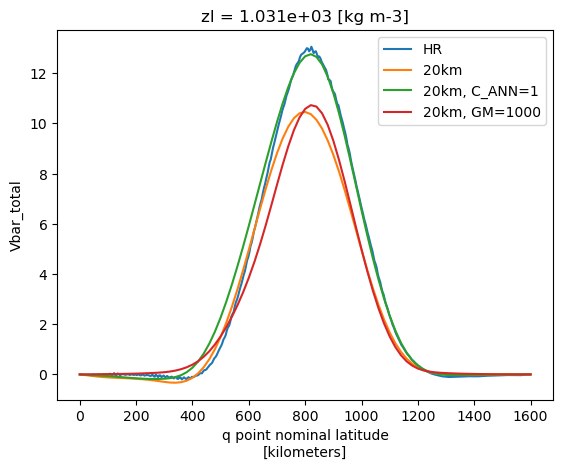

In [70]:
zl = 0
ds_HR['Vbar_resolved'].isel(zl=zl).plot(label='HR')
exp_tree['ANN']['20']['0.0']['ave_prog'].Vbar_total.isel(zl=zl).plot(label='20km')
exp_tree['ANN']['20']['1.0']['ave_prog'].Vbar_total.isel(zl=zl).plot(label='20km, C_ANN=1')
exp_tree['GM1000']['20']['1.0']['ave_prog'].Vbar_total.isel(zl=zl).plot(label='20km, GM=1000')
plt.legend()


In [71]:
Vbar_max_HR = np.max(ds_HR.Vbar_resolved.isel(zl=zl).values)

In [72]:
Vbar_max_ANN = np.zeros((len(res), len(C_ANN)))
zl = 0
for i, r in enumerate(res):
    for j, c in enumerate(C_ANN):
        Vbar_max_ANN[i][j] = np.max(exp_tree['ANN'][str(r)][str(c)]['ave_prog'].Vbar_total.isel(zl=zl))

In [73]:
Vbar_max_GM = np.zeros((len(res), len(C_GM)))
zl = 0
for i, r in enumerate(res):
    for j, c in enumerate(C_GM):
        Vbar_max_GM[i][j] = np.max(exp_tree['GM1000'][str(r)][str(c)]['ave_prog'].Vbar_total.isel(zl=zl))

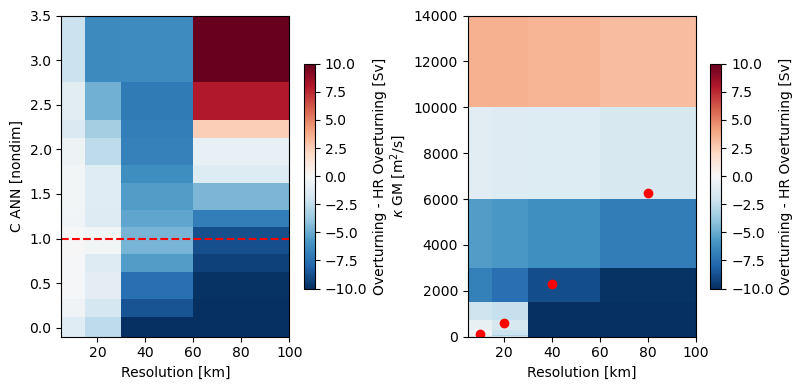

In [75]:
plt.figure(figsize=(8,4))

plt.subplot(121)
#levels = np.linspace(-13, 13, 27)
levels = np.linspace(-7, 7, 27)
max_vals = 10
cf = plt.pcolormesh(res_bins, C_ANN_bins, (Vbar_max_ANN - Vbar_max_HR).T, cmap='RdBu_r',  
                    vmin=-max_vals, vmax=max_vals)

plt.hlines(1, min(res_bins), max(res_bins), linestyle='dashed', colors='r')

# Colorbar and labels
plt.colorbar(cf, label='Overturning - HR Overturning [Sv]', shrink=0.7)
plt.xlabel('Resolution [km]')
plt.ylabel('C ANN [nondim]')

plt.subplot(122)
# Filled contours
cf = plt.pcolormesh(res_bins, C_GM_bins, (Vbar_max_GM - Vbar_max_HR).T, cmap='RdBu_r',  
                    vmin=-max_vals, vmax=max_vals)

for i, r in enumerate(res):
    plt.plot(res[i], C_GM_offline_P2L[i], marker='o', color='r')

# Colorbar and labels
cbar = plt.colorbar(cf, label='Overturning - HR Overturning [Sv]', shrink=0.7)
#cbar.ax.tick_params(labelrotation=45)  # Rotate tick labels

plt.xlabel('Resolution [km]')
plt.ylabel('$\kappa$ GM [m$^2$/s]')

plt.tight_layout()
plt.savefig('sensitivity_P2L.png')

Text(0, 0.5, 'C GM')

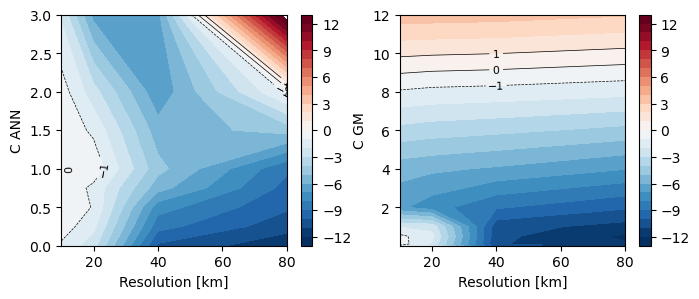

In [17]:
plt.figure(figsize=(8,3))

plt.subplot(121)
levels = np.linspace(-13, 13, 27)
# Filled contours
cf = plt.contourf(res, C_ANN, (Vbar_max_ANN - Vbar_max_HR).T, cmap='RdBu_r', levels=levels, vmin=-12, vmax=12)

# Contour lines (for labeling)
cs = plt.contour(res, C_ANN, (Vbar_max_ANN - Vbar_max_HR).T, levels=[-1,0,1], colors='black', linewidths=0.5)

# Add labels to contour lines
plt.clabel(cs, inline=True, fontsize=8)

# Colorbar and labels
plt.colorbar(cf)
plt.xlabel('Resolution [km]')
plt.ylabel('C ANN')

plt.subplot(122)
# Filled contours
cf = plt.contourf(res, C_GM, (Vbar_max_GM - Vbar_max_HR).T, cmap='RdBu_r', levels=levels, vmin=-12, vmax=12)

# Contour lines (for labeling)
cs = plt.contour(res, C_GM, (Vbar_max_GM - Vbar_max_HR).T, levels=[-1,0,1], colors='black', linewidths=0.5)

# Add labels to contour lines
plt.clabel(cs, inline=True, fontsize=8)

# Colorbar and labels
plt.colorbar(cf)
plt.xlabel('Resolution [km]')
plt.ylabel('C GM')
